In [1]:
import sqlite3
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import style
#style.use('ggplot')
from collections import OrderedDict
from wordcloud import WordCloud
from pprint import pprint
import random 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import emoji

Итак, мы имеем базу данных на 20294 поста. Проанализируем некоторые аспекты.

In [2]:
conn = sqlite3.connect('my_groups.db')
cur = conn.cursor()

Рассмотрим сначала **число лайков** на постах.

<AxesSubplot:ylabel='Density'>

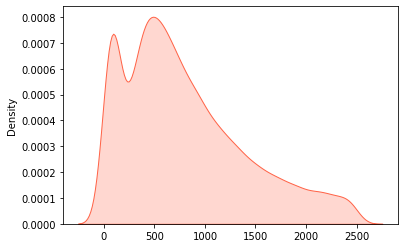

In [3]:
likes_query = """
SELECT likes
FROM posts
"""
cur.execute(likes_query)
likes = cur.fetchall()
my_likes = [i[0] for i in likes if i[0] <= 2500]

sns.kdeplot(my_likes, shade=True, color="tomato")

Я бы скорее ожидала распределения либо с одним пиком, либо просто "гладкое" и "пологое". Заметно, однако, что распределение совсем не такое.

Вероятно, это связано с тем, что анализ производился по всем группам сразу. Тоггда посмотрим, что можно сказать о распределении лайков в каждой конкретной группе.

In [4]:
group_query = """
SELECT domain
FROM posts
"""

cur.execute(group_query)
groups = cur.fetchall()
my_groups = list(set(groups))

In [5]:
colors = ['red', 'orange', 'olive', 'cyan', 'purple', 'magenta', 'lime',
         'gray', 'gold', 'lightpink', 'lightskyblue']

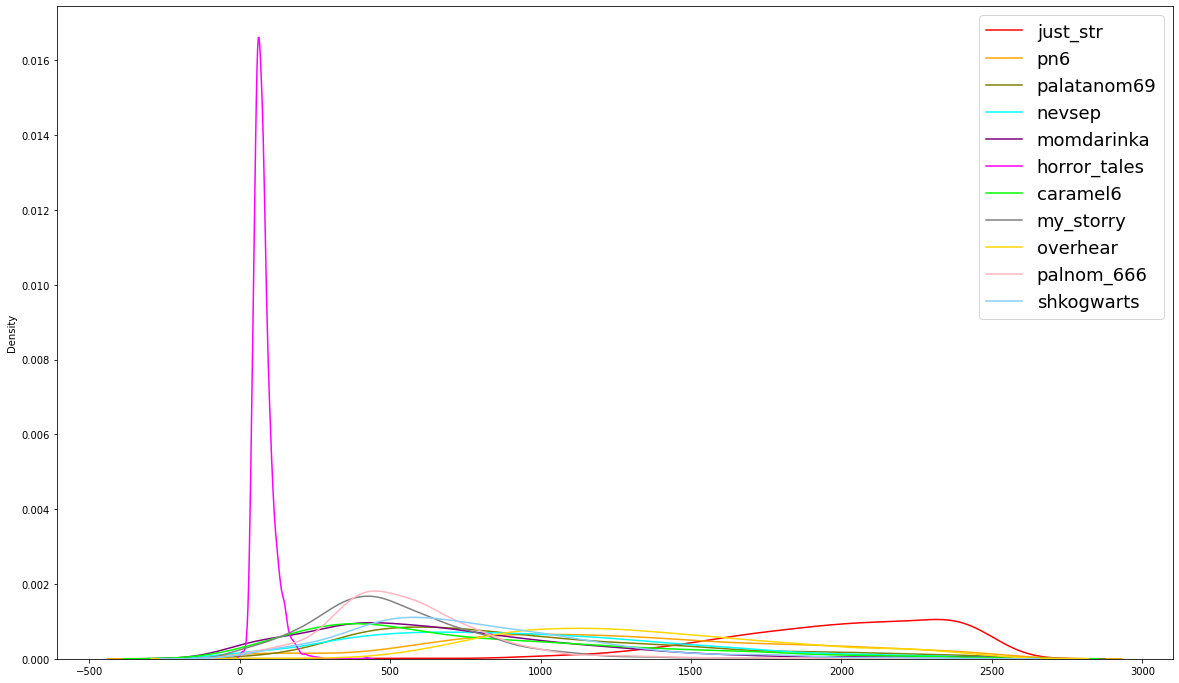

In [6]:
plt.figure(figsize=(20,12))
for g in range(len(my_groups)):
    likes_query = """
    SELECT likes
    FROM posts
    WHERE domain = ?
    """
    cur.execute(likes_query, my_groups[g])
    likes = cur.fetchall()
    #print(g, my_groups[g], colors[g])
    my_likes = [i[0] for i in likes if i[0] <= 2500]
    sns.kdeplot(my_likes, shade=False, color=colors[g], label = my_groups[g][0])
    plt.legend(fontsize = 18)

Это ближе к ожидаемому.

Интересно заметить, что две группы сильно выбиваются из общей картины.

In [7]:
len(my_groups)

11

Рассморим распределение наиболее распространённых **частей речи**.

In [8]:
'''parts = ['NOUN', 'PREP', 'PRCL', 'VERB', 'ADJF',
       'ADVB', 'CONJ', 'NPRO', 'INTJ', 'PRED',
       'ADJS', 'PRTF', 'NUMR', 'GRND', 'COMP', 'PRTS']'''

parts = ['NOUN', 'VERB', 'ADJF', 'ADVB']

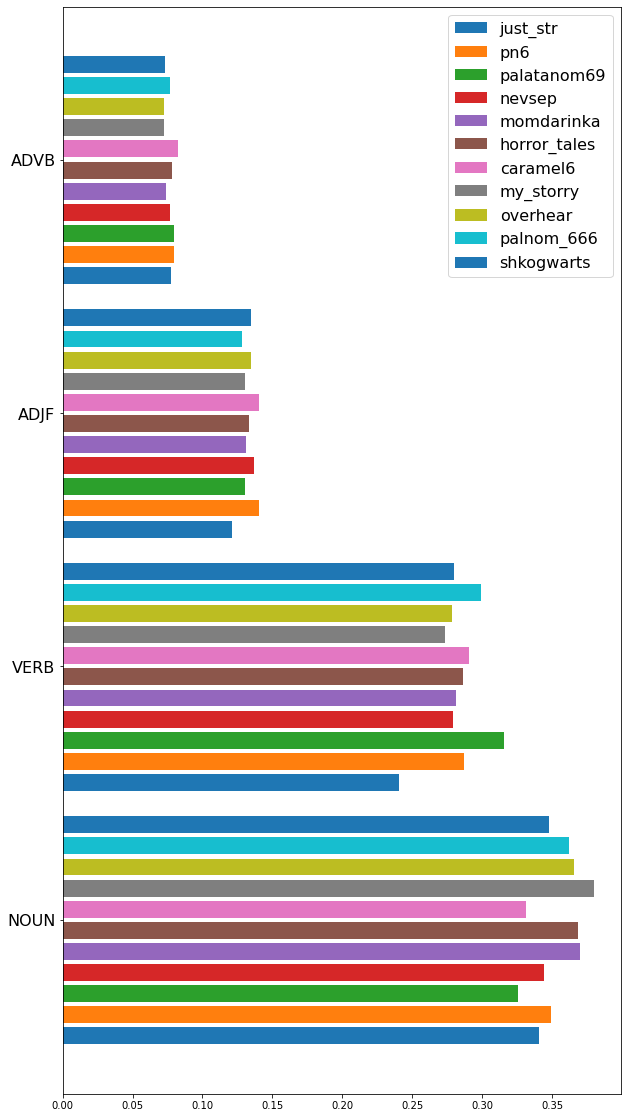

In [9]:
plt.figure(figsize=(10,20))
for g in range(len(my_groups)):
    pos_query = """
    SELECT pos
    FROM posts
    WHERE domain = ?
    """
    cur.execute(pos_query, my_groups[g])
    pos = cur.fetchall()
    my_pos = []
    y_pos = [i*12+g for i in range(4)]
    for p in pos:
        #print(p)
        my_pos.extend(p[0].split(' '))
    c_pos = Counter(my_pos)
    height = []
    for part in parts:
        height.append(c_pos[part]/len(my_pos))
    #print(y_pos)
    plt.barh(y_pos, height, label = my_groups[g][0])
    #print(len(height))
ticks = [i*12+5.5 for i in range(4)]
plt.yticks(ticks, parts, fontsize = 16)
plt.legend(fontsize = 16)

Рассчитаем **TF-IDF**

In [10]:
texts = []
groups = []
for g in range(len(my_groups)):
    text_query = """
    SELECT post_lemmas
    FROM posts
    WHERE domain = ?
    """
    cur.execute(text_query, my_groups[g])
    t = cur.fetchall()
    my_text = []
    for tt in t:
        #print(tt)
        my_text.append(tt[0])
    new_text = ' '.join(my_text)
    texts.append(new_text)
    groups.append(my_groups[g][0])
    #print(my_text[:29])

In [11]:
articles_preprocessed = texts
stops = stopwords.words("russian") + ['это', 'который', 'свой', 'каждый']

In [12]:
tfidf = TfidfVectorizer(
    analyzer="word",
    stop_words=stops
)

articles_tfidf = tfidf.fit_transform(articles_preprocessed)
print(f"Матрица на {articles_tfidf.shape[0]} документов и {articles_tfidf.shape[1]} термов")

Матрица на 11 документов и 56682 термов


In [13]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

feature_names = np.array(tfidf.get_feature_names())

for i, article in enumerate(groups):
    # напечатаю только первые 5 статей
    article_vector = articles_tfidf[i, :]
    words = get_top_tf_idf_words(article_vector, feature_names, 20)
    print(article)
    print(words)

just_str
['год' 'говорить' 'ребенок' 'день' 'сказать' 'мочь' 'человек' 'время'
 'работа' 'знать' 'мама' 'ee' 'очень' 'весь' 'становиться' 'понимать'
 'просто' 'давать' 'начинать' 'наш']
pn6
['год' 'день' 'очень' 'друг' 'человек' 'просто' 'начинать' 'мама' 'время'
 'сказать' 'ребенок' 'говорить' 'парень' 'мочь' 'весь' 'работа' 'понимать'
 'становиться' 'знать' 'решать']
palatanom69
['парень' 'друг' 'девушка' 'начинать' 'сказать' 'год' 'день' 'время'
 'секс' 'хотеть' 'говорить' 'мочь' 'просто' 'понимать' 'очень' 'муж'
 'знать' 'решать' 'наш' 'любить']
nevsep
['день' 'год' 'очень' 'говорить' 'просто' 'человек' 'мама' 'время'
 'начинать' 'сказать' 'друг' 'весь' 'понимать' 'хотеть' 'мочь' 'решать'
 'знать' 'становиться' 'ребенок' 'парень']
momdarinka
['ребенок' 'муж' 'год' 'сын' 'мама' 'день' 'говорить' 'дочка' 'очень'
 'сказать' 'хотеть' 'дочь' 'наш' 'просто' 'понимать' 'весь' 'знать'
 'время' 'начинать' 'мочь']
horror_tales
['становиться' 'дверь' 'год' 'человек' 'мочь' 'сказать' 'дом' 'ру

Кажется, что довольно очевидна разница в тематиках текстов в группах с определённым направлением:

- *ребёнок*, *муж*, *сын* и т. п. в группе с историями матерей;

- *класс*, *школа*, *урок* в группе для школьников.

С другой стороны, наборы слов группах без чётко заданного направления довольно похожи.

Посмотрим на использованные **смайлики**.

Хотя не все символы удалось достать из текстов, можно порпробовать сделать какие-либо выводы из того, что получилось

In [14]:
smiles = {}
for g in range(len(my_groups)):
    smiles_query = """
    SELECT smiles
    FROM posts
    WHERE domain = ?
    """
    cur.execute(smiles_query, my_groups[g])
    s = cur.fetchall()
    my_smiles = []
    for smile in s:
        if not smile[0] == '':
            for s in smile[0]:
                my_smiles.append(s)
    smiles[my_groups[g][0]] = my_smiles

In [15]:
for k, v in smiles.items():
    print(k, len(v))
    c = Counter(v).most_common(15)
    for l in c:
        print(emoji.emojize(l[0]), l[1], end = ' ')
    print('')

just_str 7
😍 1 😬 1 💃 1 🔥 1 🎁 1 💲 1 🌐 1 
pn6 168
🔥 17 😉 11 😅 9 😎 9 🏻 8 😍 8 😂 7 😜 7 😁 5 💪 4 😇 4 🤗 3 💛 3 😃 3 👇 3 
palatanom69 531
😅 41 😏 40 🏻 28 😆 27 😑 23 😌 20 😍 20 🤗 17 😃 15 😄 14 😒 14 😉 14 😁 14 😂 14 😇 14 
nevsep 286
🥰 39 😸 27 📌 19 🏻 18 😉 17 👉 14 😊 10 😏 7 🌺 7 🤗 6 😅 6 😍 5 😁 5 😱 5 😔 4 
momdarinka 618
😉 43 😂 32 🏻 31 😃 30 🎁 19 😘 17 🌟 15 🤣 15 😌 14 😊 13 🧡 13 😍 11 👇 11 🔥 11 😁 10 
horror_tales 14
🎄 4 🔥 2 😕 2 🎁 1 🥰 1 🚀 1 👉 1 🏻 1 😠 1 
caramel6 451
💜 34 🏻 32 😉 28 😘 23 😂 20 🙏 18 😃 18 😔 15 😭 14 😁 14 👇 11 😇 10 😍 10 😄 9 😅 8 
my_storry 49
🤣 5 🔸 3 😆 3 👉 3 😑 2 👩 2 🎓 2 😉 2 😀 2 😂 2 😁 2 🏻 2 😨 2 🙏 1 🙃 1 
overhear 38
😂 7 😄 4 😀 3 😩 3 🤦 2 😅 2 😊 2 😌 1 🙁 1 😓 1 😭 1 😈 1 🤣 1 😣 1 🙉 1 
palnom_666 192
🏻 16 😏 16 🖤 11 😱 11 👉 10 👻 9 😉 6 😈 6 😮 6 🎁 5 🥰 5 🚀 5 🔥 5 🎬 5 🌿 5 
shkogwarts 687
🎉 41 🏻 40 😂 34 😅 28 😭 21 🍁 18 🦉 16 😉 15 🥰 14 😍 14 😃 13 🤦 13 😔 12 😊 12 👋 12 


- Заметно, что использование смайликов сильно разнится в количественном отношении: так, некоторые группы наименее склонны публиковать посты с эмодзи;
- Кроме того, различаются и использованные смайлы, хотя я не знаю, с чем это связано.

Ещё я решила посмотреть на **стилометрический анализ** (R, Gephi). Для этого надо было ещё записать все тексты постов в txt-файлы.


Вообще очевидно, что поскольку группы позиционируют себя, как публикующие истории подписчиков, ожидать авторского сигнала не стоит. Однако любопытно заметить, что большинство групп, которые неким образом связаны (средняя ветка на рисунке; по крайней мере, они все ссылаются друг на друга), оказались близки.

Кроме того, группы со страшными историями так же имеют сходный стиль.
<img src='https://raw.githubusercontent.com/YanaKoko/project_2021/main/дерево.png'>
<img src='https://raw.githubusercontent.com/YanaKoko/project_2021/main/связи.png'>